<a href="https://colab.research.google.com/github/lalit527/DL/blob/master/Deep_Learning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai==0.7.0
!{sys.executable} -m pip install torchtext==0.2.3
!curl http://files.fast.ai/data/dogscats.zip --output sample_data/dogscats.zip
!unzip sample_data/dogscats.zip  

In [ ]:
import fastai

In [ ]:
from fastai.imports import *

In [ ]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [ ]:
import os

In [ ]:
PATH = "dogscats/"
sz = 224

In [23]:
torch.cuda.is_available()

True

In [24]:
torch.backends.cudnn.enabled

True

In [26]:
os.listdir(PATH)

['models', 'sample', 'test1', 'valid', 'train']

In [27]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [28]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.5631.jpg',
 'cat.2173.jpg',
 'cat.11600.jpg',
 'cat.4058.jpg',
 'cat.5973.jpg']

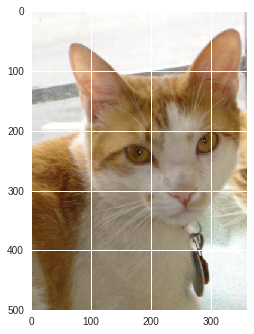

In [29]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [30]:
img.shape

(500, 361, 3)

In [31]:
img[:4, :4]

array([[[245, 244, 240],
        [245, 244, 240],
        [245, 244, 240],
        [245, 244, 240]],

       [[246, 245, 241],
        [246, 245, 241],
        [246, 245, 241],
        [246, 245, 241]],

       [[246, 245, 241],
        [246, 245, 241],
        [246, 245, 241],
        [246, 245, 241]],

       [[247, 246, 242],
        [247, 246, 242],
        [247, 246, 242],
        [247, 246, 242]]], dtype=uint8)

In [32]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 73738540.76it/s]


100%|██████████| 32/32 [00:14<00:00,  4.17it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.04884    0.027693   0.99      
    1      0.043652   0.027458   0.99      



[array([0.02746]), 0.99]

In [33]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
data.classes

['cats', 'dogs']

In [35]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [36]:
log_preds[:10]

array([[ -0.00159,  -6.44538],
       [ -0.00061,  -7.4049 ],
       [ -0.00002, -10.88946],
       [ -0.00069,  -7.27536],
       [ -0.00227,  -6.08891],
       [ -0.00037,  -7.91454],
       [ -0.00007,  -9.59214],
       [ -0.00001, -11.29273],
       [ -0.00012,  -9.02868],
       [ -0.00002, -10.89366]], dtype=float32)

In [ ]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:, 1])

In [ ]:
def rand_by_mask(mask): 
  return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
  return rand_by_mask((preds == data.val_y) == is_correct)

In [ ]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
  f = plt.figure(figsize=figsize)
  for i in range(len(ims)):
    sp = f.add_subplot(rows, len(ims) // rows, i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx):
  return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
  imgs = [load_img_id(data.val_ds, x) for x in idxs]
  title_probs = [probs[x] for x in idxs]
  print(title)
  return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found')

Correctly classified


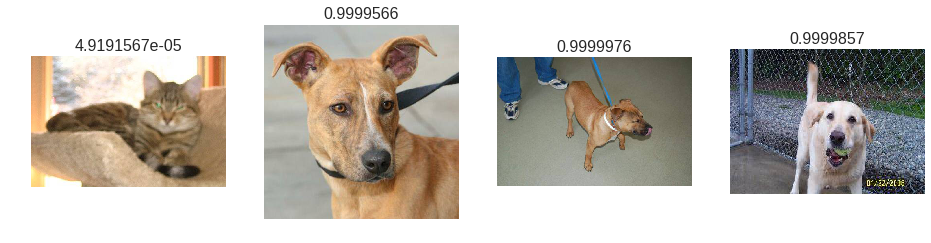

In [52]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


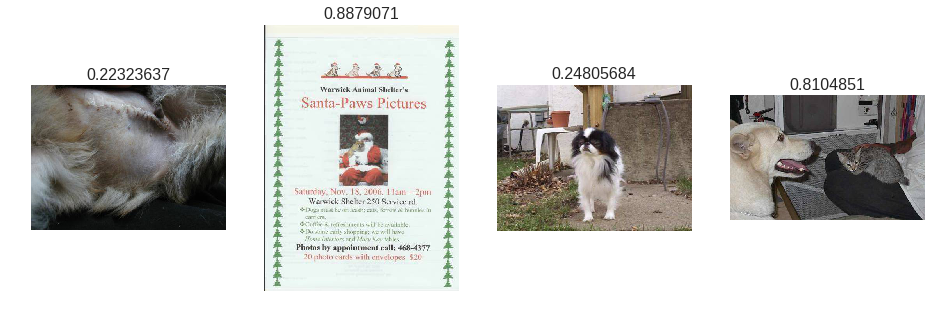

In [53]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [ ]:
def most_by_mask(mask, mult):
  idxs = np.where(mask)[0]
  return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
  mult = -1 if(y==1)==is_correct else 1
  return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


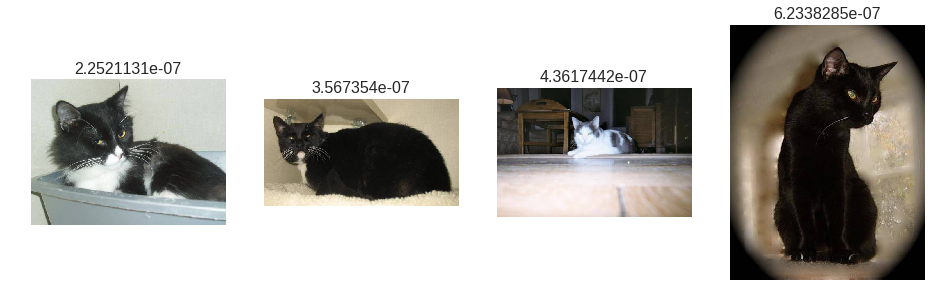

In [55]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


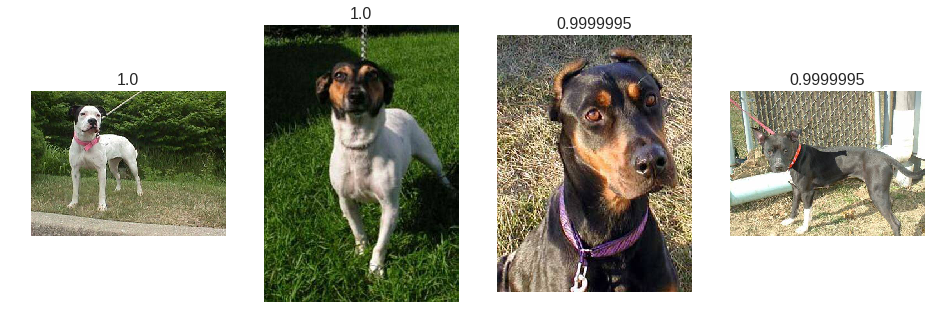

In [56]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


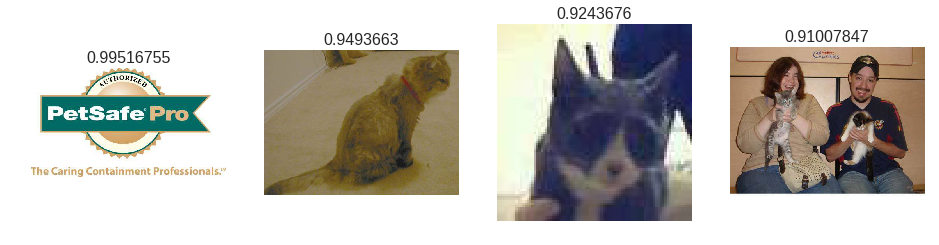

In [57]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


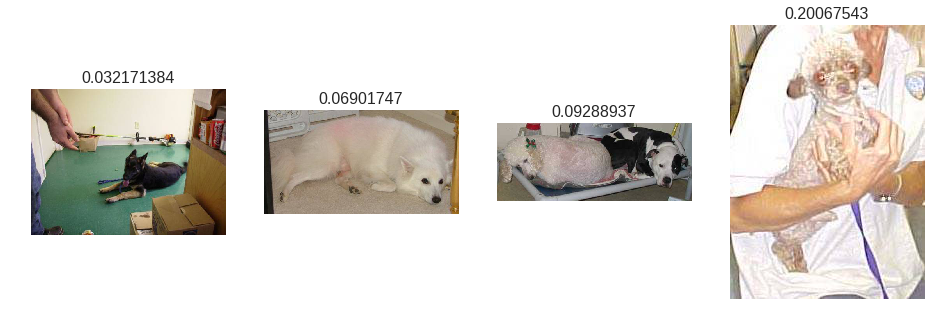

In [58]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


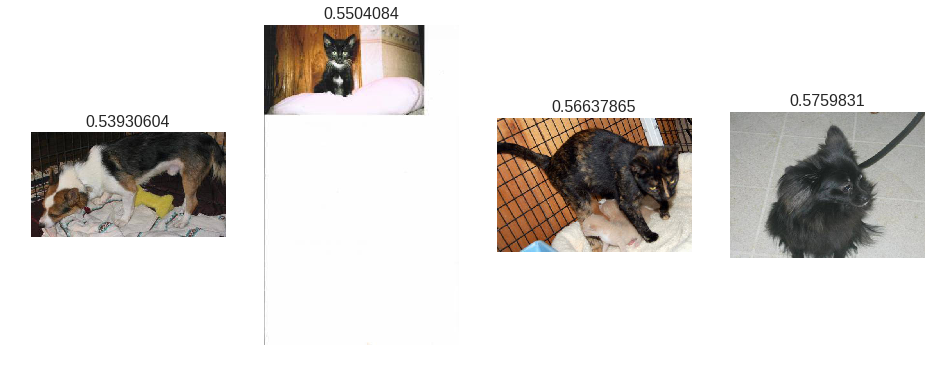

In [59]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [61]:
lrf=learn.lr_find()

 84%|████████▍ | 303/360 [00:05<00:00, 57.28it/s, loss=0.473]


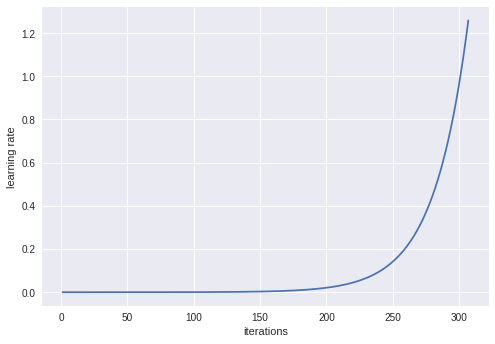

In [62]:
learn.sched.plot_lr()

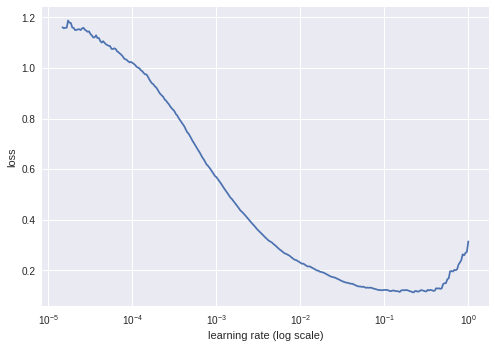

In [63]:
learn.sched.plot()